In [1]:
! nvidia-smi

Tue Nov 15 08:40:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 35%   68C    P2   189W / 350W |  20790MiB / 24576MiB |     93%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 34%   

In [2]:
import os, random, string 

cuda_device = 5
os.environ["CUDA_VISIBLE_DEVICES"] = str(cuda_device)

In [3]:
# "Basic" py library
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Stats 
from mlxtend.evaluate import permutation_test
from scipy.stats import spearmanr

# visualisation
from matplotlib import pyplot as plt # basic visualisation in py
import seaborn as sns # great to interact with dataframes
import plotly.express as px # powerfull for interactive figures
from tqdm import tqdm  # generats progress bar to controll steps

# ML 
import torch # Pytorch, Meta's library for ML
import torch.nn as nn # torch module for neural networks 

import transformers # HuggingFace library to use pretrained models
from transformers import BertTokenizer, BertModel
from transformers import pipeline
import datasets

In [4]:
def set_seed(seed: int):
    """Helper function for reproducible behavior to set the seed in ``random``, 
        ``numpy``, ``torch`` and/or ``tf`` (if installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
    
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)
             
def get_PN_em(x, neg_em_list):
    if x in neg_em_list:
        return "Negative"
    elif x == "HA":
        return "Positive"
    else:
        return "Missing"
 
Coding_emotions = {
    "AN": "Anger",
    "AP": "Apprehension",
    "SD": "Sadness",
    "CO": "Confusion",
    "HA": "Happiness",
    
    "Missing": "Missing",
}

def Coding_em_binary_P(emotion_str):
    if emotion_str == "AP": 
        return "Positive"
    elif emotion_str == "Missing":
        return "Missing"
    else:
        return "Negative"

def get_Dreamer_SA_scores(dream_records, emotions="Dreamer", N_emotions="one", reference_Sentiment="POSITIVE"):
    
    """Function to collect the probability of observing the reference sentiment associated 
       with specific emotions, devided by Dream-Bank collection. In other words, extract the
       probability that a report is judged by the SA model as positive/negative, devided 
       by DreamBank emotions and classes

    Args:
        dream_records: dataframe containing reports and model predictions 
        N_emotions: string, number of emotions in each report [one, >1, all]
        reference_Sentiment: string, the referece sentiment fro the SA model
    """
    
    DRlbl_SAlbl = []
    for collection in tqdm(set(dream_records["collection"])):

        if N_emotions == "one":
            lcl_df          = dream_records[
                                    dream_records["collection"].isin([collection]) & 
                                    dream_records["# {} Emotions".format(emotions)].isin([1])       
                            ]

        elif N_emotions == "all":
            lcl_df          = dream_records[
                                    dream_records["collection"].isin([collection]) & 
                                    ~dream_records["# {} Emotions".format(emotions)].isin([0])       
                            ]
            
        elif N_emotions == ">1":
            lcl_df          = dream_records[
                                    dream_records["collection"].isin([collection]) & 
                                    ~dream_records["# {} Emotions".format(emotions)].isin([0,1])        
                            ]
        else:
            print("No such setting {}".formt(N_emotions))
            break

        
        L_EM =  emotions if emotions=="Dreamer" else "All"
        lcl_DRlbl_SAlbl = {} # Dream-Report label vs Sent. Analysis label
        for emotions_seq, SA_lbl in lcl_df[["{} Emotions".format(L_EM),"2W_SA_label"]].values:

            SA_lbl_to_int = 1 if SA_lbl == reference_Sentiment else 0

            for emt in emotions_seq.split("_"):

                local_lst = lcl_DRlbl_SAlbl.get(Coding_emotions[emt], [])
                local_lst.append(SA_lbl_to_int)
                lcl_DRlbl_SAlbl[Coding_emotions[emt]] = local_lst

        lcl_DRlbl_SAlbl = [
            [k,(sum(v)/len(v)), collection] for k,v in lcl_DRlbl_SAlbl.items()
        ]
        
        for trpl in lcl_DRlbl_SAlbl:
            DRlbl_SAlbl.append(trpl)
       
    return DRlbl_SAlbl

def get_general_sentiment(dream_records, Emotion_to_Score, emotions="General"):
    
    DRlbl_SAlbl = [] # Dream-Report label vs Sent. Analysis label
    for collection in set(dream_records["collection"]):
        lcl_df = dream_records[
                        dream_records["collection"].isin([collection]) & 
                        ~dream_records["# {} Emotions".format(emotions)].isin([0])       
        ]

        L_EM =  emotions if emotions=="Dreamer" else "All"
        for emotions_seq, SA_lbl, SA_scr in lcl_df[["{} Emotions".format(L_EM), "2W_SA_label", "2W_SA_score"]].values:

            general_sentiment    = sum(list(map(lambda e: Emotion_to_Score[e], emotions_seq.split("_"))))
            general_predicted_SA = SA_scr if SA_lbl == "POSITIVE" else -SA_scr
            DRlbl_SAlbl.append([emotions_seq, general_sentiment, general_predicted_SA, collection])

    DRlbl_SAlbl = pd.DataFrame(DRlbl_SAlbl, columns=["Emotions", "General Sentiment", "Predicted Sentiment", "collection"])
    
    return DRlbl_SAlbl

def cutted_barplot(data, X, Y, palette, top, bottom, x_lbl, y_lbl):
    """Visualisation function, draws a "cutted" barplot for those cases where one 
        or more outliers make the visualisation complicated

    Args:
        data: df, the data to visulise 
        X, Y: string, the the name of x and y axis 
        palette: color set
        top, bottom: integer, where to interrupt and reptart the plot (on y axe)
        x_lbl, y_lbl: string, names of the labels for the axes
    """
    f, (ax_top, ax_bottom) = plt.subplots(
        ncols=1, 
        nrows=2, 
        sharex=True, 
        gridspec_kw={'hspace':0.05},
        figsize=(20,8),
    )

    g1 = sns.barplot(
        data=data,
        x=X,
        y=Y,
        palette=palette,
        ax=ax_top
    )
    g1.set_xlabel(""), g1.set_ylabel("")

    g2 = sns.barplot(
        data=data,
        x=X,
        y=Y,
        palette=palette,
        ax=ax_bottom
    )
    g2.set_xlabel(""), g2.set_ylabel("")

    ax_top.set_ylim(bottom=top)   # those limits are fake
    ax_bottom.set_ylim(0,bottom)

    sns.despine(ax=ax_bottom)
    sns.despine(ax=ax_top, bottom=True)

    ax = ax_top
    d = .005  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

    ax2 = ax_bottom
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
    )

    f.text(0.5, -.1, x_lbl, ha='center')
    f.text(.07, 0.5, y_lbl, va='center', rotation='vertical')
    plt.show()

In [5]:
# Set visual style
sns.set("talk")
sns.set_style("whitegrid")

#  set the rabdom seed
seed = 31
set_seed(seed)

# Get punctuation and English stop-words
punct         = string.punctuation 
en_stop_words = stopwords.words('english')

# Table of Content

click on the titles to reach the described sections

---------
[Loading Data](#intro)

[SA - Data Collection](#ssa)

[2-Way results](#2wresults)

[2-Way Error Analysis](#2werran)

## Loading data<a id='intro'></a>

In [5]:
# Load the dataset in CSV
dream_records = pd.read_csv(
    "Reports_with_Dreamer_and_General_Emotions_PCAxy_tSNExy_CllKmC_Gnd_KmC.csv"
)

## Sentiment Analysis - Data Collection<a id='ssa'></a>

2-Way Sentiment Analysis 

In [7]:
sent_pipeline = pipeline(
    "sentiment-analysis", 
    truncation=True, 
    max_length=512, 
    device=0,
)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [8]:
"""
SST-2 Output

{'label': 'POSITIVE', 'score': 0.9998},
"""
print()

In [9]:
raw_data = dream_records["report"].tolist()

In [10]:
predictions = [
    list(sent_pipeline(report)[0].values())
    for report in tqdm(raw_data)
]    

  0%|                                          | 1/1845 [00:00<20:39,  1.49it/s]/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/transformers/pipelines/base.py:1036: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████████████████████████████████| 1845/1845 [00:07<00:00, 249.55it/s]


In [11]:
dream_records["2W_SA_label"], dream_records["2W_SA_score"] = zip(*predictions)

6-Way Sentiment Analysis 

In [12]:
sent_pipeline = pipeline(
    "text-classification",
    model='bhadresh-savani/distilbert-base-uncased-emotion', 
    return_all_scores=True, 
    truncation=True, 
    max_length=512,
    device=0,
)

/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  warnings.warn(


In [13]:
"""
Emotion Output:
[[
{'label': 'sadness', 'score': 0.0006792712374590337}, 
{'label': 'joy', 'score': 0.9959300756454468}, 
{'label': 'love', 'score': 0.0009452480007894337}, 
{'label': 'anger', 'score': 0.0018055217806249857}, 
{'label': 'fear', 'score': 0.00041110432357527316}, 
{'label': 'surprise', 'score': 0.0002288572577526793}
]]
"""
print()

In [14]:
predictions = [
    sent_pipeline(report)
    for report in tqdm(raw_data)
]    

dream_records["6W_SA_dict"] = predictions

  0%|                                                  | 0/1845 [00:00<?, ?it/s]/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/transformers/pipelines/base.py:1036: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████████████████████████████████| 1845/1845 [00:06<00:00, 275.44it/s]


In [15]:
# # Store to .csv
# dream_records.to_csv(
#     "Reports_with_Dreamer_and_General_Emotions_PCAxy_tSNExy_CllKmC_Gnd_KmC_2WSA_6WSA.csv", 
#     index=False,
# )

## 2-Way SA Results<a id='2wresults'></a>

In [6]:
# Load the dataset in CSV (if already has BERT–Large emb. and PCA/t-SNE coordinates)
dream_records = pd.read_csv(
    "Reports_with_Dreamer_and_General_Emotions_PCAxy_tSNExy_CllKmC_Gnd_KmC_2WSA_6WSA.csv"
)

Frist, we will analysie the probability of observing the models classifying as `POSITIVE` each report. The selected class is arbitrarly choose, so to visually see whether the one postitive emotion (i.e. `Happeiness`) will be actually more associated with the `POSITIVE` label. The results will be devided by collection and emotions, and ammount of **dreameer emotions** (`# Emotions`) in each report. `# Emotions` will be devided between 1, >1 and all. However, given that the model expresses a 2-way classification, the interpretation shoul focus on `# Emotions = 1`. 

Wi will not start with a visualisation collapsed by collection, usisng a boxplot, to better graps the collection-base variance. Then, a barplot will expliclty devide the results by collections.

In [7]:
x_order = ["Anger", "Apprehension", "Confusion", "Sadness", "Missing", "Happiness"]
N_emotions = "one" # or "all"

DRlbl_SAlbl_all = get_Dreamer_SA_scores(
                    dream_records, 
                    emotions="Dreamer", 
                    N_emotions="all", 
                    reference_Sentiment="POSITIVE"
)

DRlbl_SAlbl_all_df = pd.DataFrame(
    DRlbl_SAlbl_all, columns=[
    "Emotion", "p(l=POSITIVE)", "collection"]
)

DRlbl_SAlbl_one = get_Dreamer_SA_scores(
                    dream_records, 
                    emotions="Dreamer", 
                    N_emotions="one", 
                    reference_Sentiment="POSITIVE"
)

DRlbl_SAlbl_one_df = pd.DataFrame(
    DRlbl_SAlbl_one, columns=[
    "Emotion", "p(l=POSITIVE)", "collection"]
)

DRlbl_SAlbl_mto = get_Dreamer_SA_scores(
                    dream_records, 
                    emotions="Dreamer", 
                    N_emotions=">1", 
                    reference_Sentiment="POSITIVE"
)

DRlbl_SAlbl_mto_df = pd.DataFrame(
    DRlbl_SAlbl_mto, columns=[
    "Emotion", "p(l=POSITIVE)", "collection"]
)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1047.83it/s]


In [8]:
DRlbl_SAlbl_one_df["# Emotions"] = ["1"]*len(DRlbl_SAlbl_one_df)
DRlbl_SAlbl_mto_df["# Emotions"] = [">1"]*len(DRlbl_SAlbl_mto_df)
DRlbl_SAlbl_all_df["# Emotions"] = ["all"]*len(DRlbl_SAlbl_all_df)

DRlbl_SAlbl_full_df = pd.concat([DRlbl_SAlbl_all_df, DRlbl_SAlbl_one_df, DRlbl_SAlbl_mto_df])
DRlbl_SAlbl_full_df = DRlbl_SAlbl_full_df.reset_index(drop=True)

In [9]:
x_order = ["Anger", "Apprehension", "Confusion", "Sadness","Happiness"]
col_order = ["1", ">1", "all"]

Text(0.5, 0.53, 'Random')

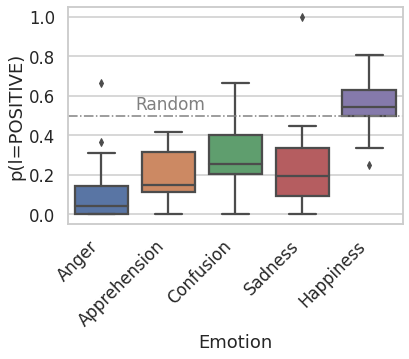

In [10]:
g = sns.boxplot(
    data=DRlbl_SAlbl_full_df, 
    x="Emotion",
    y="p(l=POSITIVE)",
    order=x_order,
)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

g.axhline(.50, ls='-.', color="gray", linewidth=1.5)
g.text(.5, .53, "Random", color="gray", fontsize=17) 

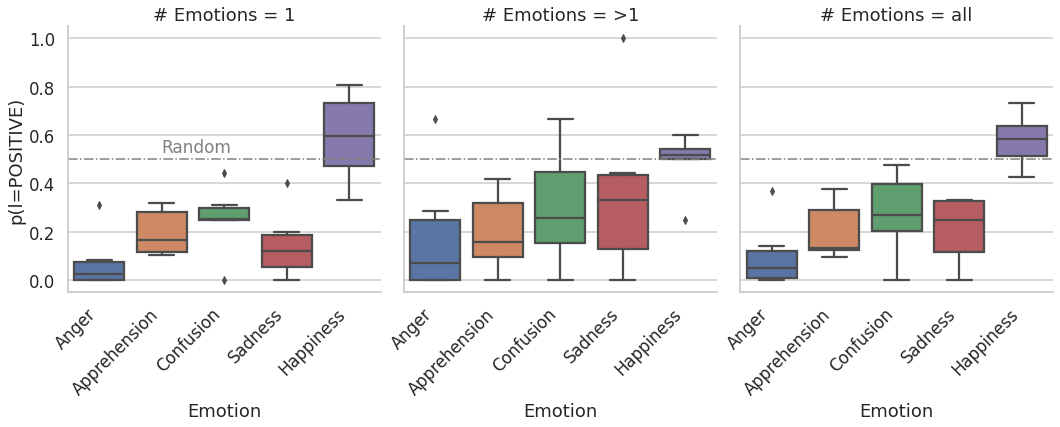

In [11]:
g = sns.catplot(
    data=DRlbl_SAlbl_full_df, 
    x="Emotion",
    y="p(l=POSITIVE)",
    order=x_order,
    col="# Emotions",
    kind="box",
    col_order=col_order,
    errorbar=("se", 1)
)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

for cnt, axes in enumerate(g.axes.flat):
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.axhline(.50, ls='-.', color="gray", linewidth=1.5)
    if cnt == 0:
        axes.text(1, .53, "Random", color="gray", fontsize=17) 
# g.savefig("SA_dream_reports_all.png", dpi=800)

The following image will unpack the results by collection, to understand how each collection imapacts the performance of the model. 

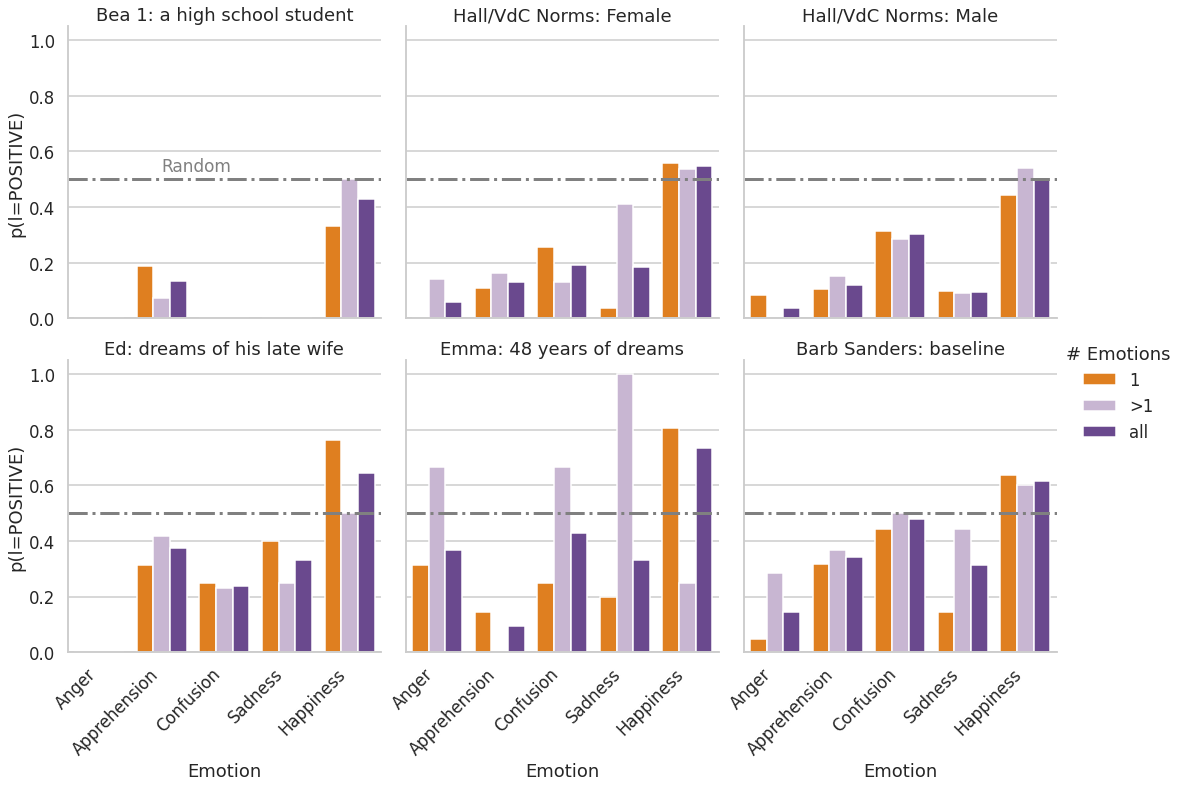

In [15]:
g = sns.catplot(
    data=DRlbl_SAlbl_full_df, 
    x="Emotion",
    y="p(l=POSITIVE)",
    order=x_order,
    col="collection",
    kind="bar",
    col_wrap=3,
    hue="# Emotions",
    hue_order=col_order,
    palette=sns.color_palette("Paired")[7:10],
)

for cnt, axes in enumerate(g.axes.flat):
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.axhline(.50, ls='-.', color="gray", linewidth=3)
    if cnt == 0:
        axes.text(1, .53, "Random", color="gray", fontsize=17) 
    
g.set_titles(template='{col_name}')

Focusing our attention on negative emotions (and `# Emotions = 1)` we can see that the model has a fairly good understanding of the dreamer-based emotional content of each report. Aside `Barb Sanders`'s `Confusion` and `Ed`'s `Sadness`, the model seems to have a good grasp on negative emotions. The same is clearly not true for the only positive emotion: `Happiness`. The model seems to decently behave with collections like `Ed`, `Emma` and `Barb`, but does randomly or worst otherwise.

We will not move our attention to the `General Sentiment` analysis, where we will compare the prediction of the model, together with its confidence, with a score-based interpretation of the general emotion of each report. To do so, we define a positive (1), negative (-1) or neutral (0) value for each emotion. After converting the list of emotions associated with each report into an integer with said method, the `General Sentiment` for each report is computed with simple addition. The gathered scores are then compared with the confidence predictions of the model. The "confidence" of the model is simply obtianed by 

In [20]:
Emotion_to_Score = {
    "AN": -1,
    "AP": -1,
    "SD": -1,
    "CO": 0,
    "HA": 1,
}

DRlbl_SAlbl = get_general_sentiment(dream_records, Emotion_to_Score, emotions="General")
for collection in tqdm(set(dream_records["collection"])):
    l_DRlbl_SAlbl = DRlbl_SAlbl[DRlbl_SAlbl["collection"].isin([collection])]
    rho, p = spearmanr(l_DRlbl_SAlbl["General Sentiment"],l_DRlbl_SAlbl["Predicted Sentiment"])
    print("Spearman rho: {:.3f}; p:{:.5f} | Collection: {}".format(rho, p, collection))

print("\nOverall:")
rho, p = spearmanr(DRlbl_SAlbl["General Sentiment"], DRlbl_SAlbl["Predicted Sentiment"])
print("Spearman rho: {:.3f}; p:{:.5f}".format(rho, p))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1396.94it/s]

Spearman rho: 0.370; p:0.00017 | Collection: Bea 1: a high school student
Spearman rho: 0.427; p:0.00000 | Collection: Hall/VdC Norms: Female
Spearman rho: 0.406; p:0.00000 | Collection: Hall/VdC Norms: Male
Spearman rho: 0.608; p:0.00000 | Collection: Ed: dreams of his late wife
Spearman rho: 0.603; p:0.00000 | Collection: Emma: 48 years of dreams
Spearman rho: 0.315; p:0.00008 | Collection: Barb Sanders: baseline

Overall:
Spearman rho: 0.450; p:0.00000


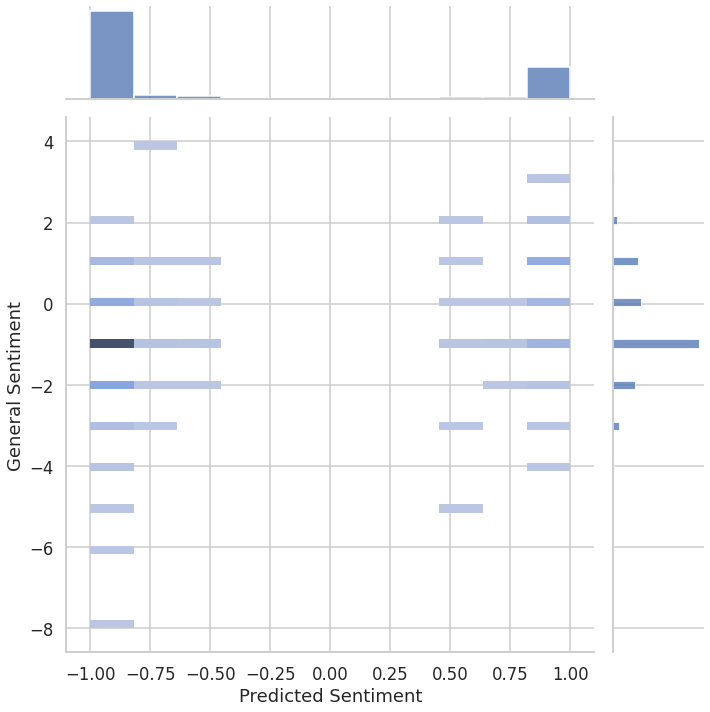

In [54]:
g = sns.jointplot(
        data=DRlbl_SAlbl, 
        y="General Sentiment", 
        x="Predicted Sentiment",
        kind="hist",
        height=10,
        ratio=5,
)

Overall, despite beeing all significantly correlated, the prediction of the model seem to have a decent grasp only on very selected collections. `Ed` and `Emma` have a resonable rho score around .60. However, in most cases, the correlation coefficents are quite low, especially under `Barb` and `Bea`. On one hand, a partial explanation for `Barb`'s results could be realted to the very low numnber of instances. On the other hand, it is interesting to notice that the model's predictions where not that off for `Bea`, in the previous test.  

As for the mode's behaviour, we noticed that the prediction always had very confident scores (i.e., the model was "quite sure" about its decision). Looking at the left-most side of the diagram, we notice that the strongest correlations seesm to lay in the negative side of the prediction. Is it expected and desired, since negatiuve emotions represent, by far, the majority class. 

## 2-Way Error Analsysis <a id='2werran'></a>

Searching for words that appear more frequenlty in those reports classified as `POSITIVE` and `Negative`, regardless of "correct" or not, and regardless of the emotition they express. 

In [24]:
sngl_em_ha_P_reports = dream_records[
    dream_records["# Dreamer Emotions"].isin([1])  &
#     dream_records["Emotions"].isin(["HA"]) &
    dream_records["2W_SA_label"].isin(["POSITIVE"])
]["report"].tolist()

pstv_wrd_frq = {}
for report in sngl_em_ha_P_reports:
    for word in word_tokenize(report):
        if word.lower() in en_stop_words or word.lower() in punct:
            continue
        pstv_wrd_frq[word.lower()] = pstv_wrd_frq.get(word.lower(), 0) + 1

In [25]:
sngl_em_nn_N_reports = dream_records[
    dream_records["# Dreamer Emotions"].isin([1])  &
#     ~dream_records["Emotions"].isin(["HA"]) &
    dream_records["2W_SA_label"].isin(["NEGATIVE"])
]["report"].tolist()

ngt_wrd_frq = {}
for report in sngl_em_nn_N_reports:
    for word in word_tokenize(report):
        if word.lower() in en_stop_words or word.lower() in punct:
            continue
        ngt_wrd_frq[word.lower()] = ngt_wrd_frq.get(word.lower(), 0) + 1

In [26]:
# Balance frequwncy so to wxpclude commmon words
pstv_wrd_frq_bl = {w:max(f-ngt_wrd_frq.get(w, 0), 0) for w,f in pstv_wrd_frq.items()}
ngt_wrd_frq_bl  = {w:max(f-pstv_wrd_frq.get(w, 0), 0) for w,f in ngt_wrd_frq.items()}

In [27]:
pstv_wrd_frq_df = pd.DataFrame(
                                list(pstv_wrd_frq_bl.items()), 
                                columns=["Word", "Frequency"]
)

ngt_wrd_frq_df = pd.DataFrame(
                                list(ngt_wrd_frq_bl.items()), 
                                columns=["Word", "Frequency"]
)

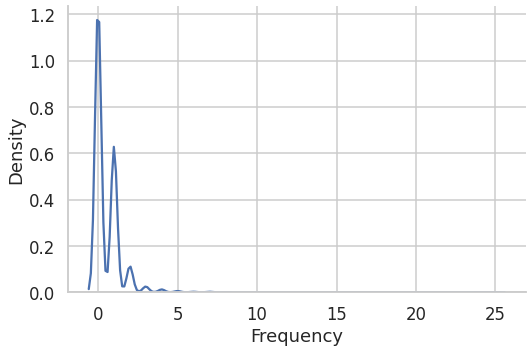

In [32]:
sns.displot(
    pstv_wrd_frq_df,
    x="Frequency", 
    kind="kde",
    aspect=1.5,
)

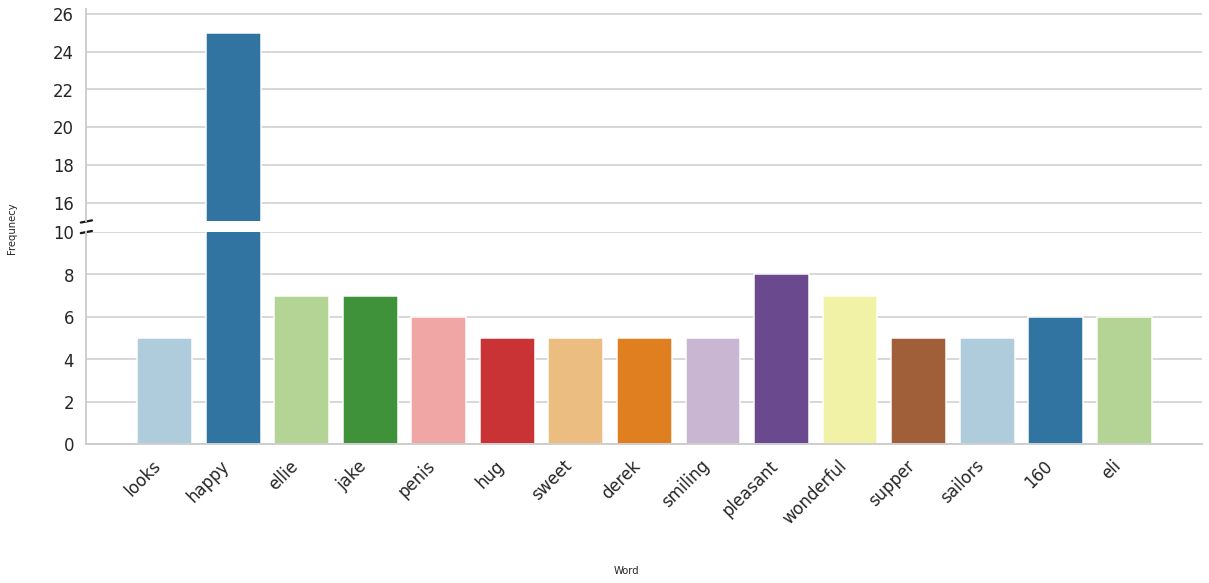

In [29]:
cutted_barplot(
pstv_wrd_frq_df[pstv_wrd_frq_df["Frequency"] >= 5], 
"Word", 
"Frequency", 
"Paired", 
15, 
10, 
"Word", 
"Frequnecy"
)

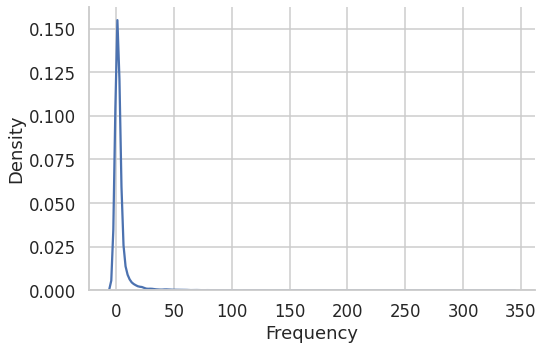

In [33]:
sns.displot(
    ngt_wrd_frq_df,
    x="Frequency", 
    kind="kde",
    aspect=1.5,
)

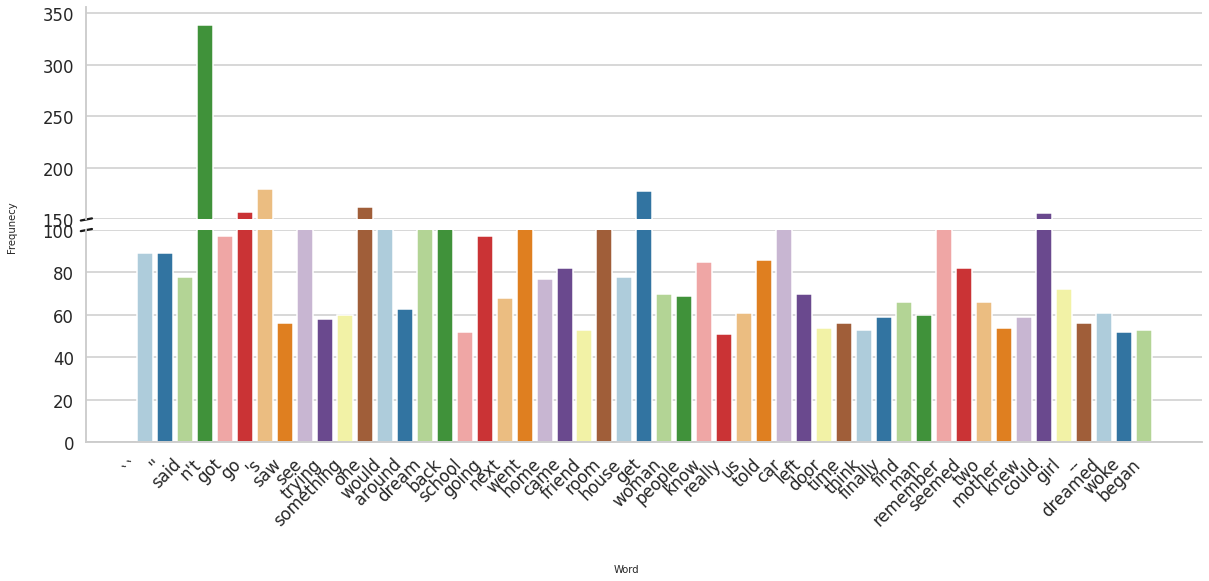

In [34]:
cutted_barplot(
ngt_wrd_frq_df[ngt_wrd_frq_df["Frequency"] > 50],
"Word", 
"Frequency", 
"Paired", 
150,
100, 
"Word", 
"Frequnecy",
)

Aside the exception of `happy`, the error analysis does not seem to suggest a clear set of words driving the model to one of the two labels. This, at least, with respet to absolute frequency. Two possible explanation can be proposed. 

Likely, it is more about *interaction* between words, rather than single words. 